# NLP Assignment 1 (40% of grade): Text classification for Fake News Detection

This coursework will involve you implementing functions for a text classifier, which you will train to detect **fake news** in a corpus of approx. 10,000 statements, which will be split into a 80%/20% training/test split. 

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [1]:
!pip install nltk

In [2]:
import csv    # csv reader
import nltk  
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4') 
nltk.download('stopwords')                        
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn import metrics
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import ngrams


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gadad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gadad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gadad\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gadad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#defining list of punctuations to remove
punctuations = [".",",",":",";","'"," ",'"',"_","!","(",")","[","]","-","=","+"]
#defining list of stop words to remove 
stop_words = ["a","an","the",]

In [4]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    # mentioning encoding ="utf-8" to avoid python compatiblity error
    with open(path, encoding="utf-8") as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text, subject, speaker, job_title,state_info,party_affiliation, barely_true_counts,false_counts, half_true_counts, mostly_true_counts, pants_on_fire_counts) = parse_data_line(line)
            raw_data.append((text,subject, speaker, job_title,state_info,party_affiliation, barely_true_counts,false_counts, half_true_counts, mostly_true_counts, pants_on_fire_counts, label))

def split_and_preprocess_data(percentage):

    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text,subject, speaker, job_title,state_info,party_affiliation, barely_true_counts,false_counts, half_true_counts, mostly_true_counts, pants_on_fire_counts, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text), subject, speaker, job_title,state_info,party_affiliation, barely_true_counts,false_counts, half_true_counts, mostly_true_counts, pants_on_fire_counts),label))
    for (text, subject, speaker, job_title,state_info,party_affiliation, barely_true_counts,false_counts, half_true_counts, mostly_true_counts, pants_on_fire_counts,label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text),subject, speaker, job_title,state_info,party_affiliation, barely_true_counts,false_counts, half_true_counts, mostly_true_counts, pants_on_fire_counts),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [5]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):
    # Should return a tuple of the label as just FAKE or REAL and the statement
    # e.g. (label, statement)
    #Adding extra features from the file to return
    statement=data_line[2]
    subject = data_line[3]
    speaker = data_line[4]
    job_title= data_line[5]
    state_info = data_line[6]
    party_affiliation = data_line[7]
    barely_true_counts = int(data_line[8])
    false_counts = int(data_line[9])
    half_true_counts =int(data_line[10])
    mostly_true_counts = int(data_line[11])
    pants_on_fire_counts = int(data_line[12])
    context = data_line[13]
    label=data_line[1]
    
    #Converting the 6 types of labels into tow ie. "Real" and "Fake"
    label=convert_label(label)
    return (label, statement + context, subject, speaker, job_title,state_info,party_affiliation, barely_true_counts,false_counts, half_true_counts, mostly_true_counts, pants_on_fire_counts)

In [6]:

# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    #Answer: we are using TweetTokenizer method from nltk.tokenize to return a list of tokens
    tokenizer= TweetTokenizer()
    tokens= tokenizer.tokenize(text)
    #Removing punctuation
    tokens= [token for token in tokens if not token in punctuations ]
    #normalization 
    tokens= [token.lower() for token in tokens]
    #lemmatization
    lemmatizer= WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, pos="r") for token in tokens]
    #stopword removal
    tokens= [token for token in tokens if not token in stop_words ]
    #Bigrams
    # tokens= ngrams(tokens,2)
    #trigrams
    #tokens= ngrams(tokens,3)
    #4-grams
    # tokens= ngrams(tokens,4)

    #Adding special stylish features like number of words per sentence
    if len(tokens)>9:
        tokens.append("long")
    else:
        tokens.append("short")        

    return tokens


In [7]:
# Basic Feature Extraction

global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens, subject, speaker, job_title,state_info,party_affiliation, barely_true_counts,false_counts, half_true_counts, mostly_true_counts, pants_on_fire_counts):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    # feature_vector is a dictionary which has words as its keys. Values for these keys are weights. Weights are defined as number of occurrences of a word.
    # Here, FreqDist method from nltk is used to get feature_vector dictionary. 
    frequency_dict= dict(FreqDist(tokens)) 
    # Keeping weight to be simply 1 for each word
    
    feature_vector = {}
    for key in  list(frequency_dict.keys()):
        feature_vector[key] = 1
        
    #Adding extra features from the file
    feature_vector["subject"] = subject
    feature_vector["speaker"] = speaker
    feature_vector["job_title"] = job_title
    feature_vector["state_info"] = state_info
    feature_vector["party_affiliation"] = party_affiliation
    feature_vector["barely_true_counts"] = barely_true_counts
    feature_vector["false_counts"] = false_counts
    feature_vector["half_true_counts"] = half_true_counts
    feature_vector["mostly_true_counts"] = mostly_true_counts
    feature_vector["pants_on_fire_counts"] = pants_on_fire_counts
    # Keeping weight to be frequency of each word
    #remove the following comments to change the weighting to frequency of words
    '''
    feature_vector = {}
    for key in  list(frequency_dict.keys()):
        feature_vector[key] = frequency_dict[key]
    '''
    # features is defined as the list. global_feature_dict contains keys as words and values as weights. We are making a list of only keys from global_feature_dict. 
    #In following code we are building  global_feature_dict incremently. Where, if word is already present in global_feature_dict then only weights are updated 
    # else keys and weights are updated.
    features= list(global_feature_dict.keys())
    for feature in list(feature_vector.keys()):
        if feature in features:
            global_feature_dict[feature] = global_feature_dict[feature] + feature_vector[feature]
        else:
            global_feature_dict[feature] = feature_vector[feature]
    return feature_vector

In [8]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    #Using class weights as dictionary 
    pipeline =  Pipeline([('svc', LinearSVC(dual=False,class_weight={0:0.4,1:0.6},max_iter=10000))])
    

    #tried below mentioned combinations for loss and class weights
    '''
    pipeline =  Pipeline([('svc', LinearSVC(class_weight={0:0.1,1:0.9},max_iter=2000))])
    pipeline =  Pipeline([('svc', LinearSVC(class_weight={0:0.9,1:0.1},max_iter=2000))])
    pipeline =  Pipeline([('svc', LinearSVC(class_weight={0:0.2,1:0.8},max_iter=2000))])
    pipeline =  Pipeline([('svc', LinearSVC(class_weight={0:0.3,1:0.7},max_iter=2000))])
    pipeline =  Pipeline([('svc', LinearSVC(loss="hinge", class_weight={0:0.4,1:0.6},max_iter=2000))])
    '''
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [9]:
#Cross-validation

from nltk.metrics.scores import precision
#solution
from sklearn.metrics import classification_report


def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1
    
    
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        #printing the fold start and end per fold
        print("Fold start on items %d - %d" % (i, i+fold_size))
        #defining the labeled_featuresets which contains features and labels as tuples
        labeled_featuresets = []
        # for loop to accomodate all samples in last fold
        for train_ix in [ x for x in list(range(len(dataset))) if x not in list(range(i, min(len(dataset),i+fold_size+1),1))]:
            labeled_featuresets.append(dataset[train_ix])
        #defining the featuresets_val which is validation feature sets
        featuresets_val = []
        #defining the labelsets_val which is validation label sets
        labelsets_val = []
        #for loop to obtain validation feature and labels
        for val_ix in [x for x in list(range(i, min(len(dataset),i+fold_size+1),1))]:
            (features,labels) = dataset[val_ix]
            featuresets_val.append(features)
            labelsets_val.append(labels) 
        # Training classifier on labeled feature sets
        classifier = train_classifier(labeled_featuresets)
        # Predicting on validation features using classifier 
        predictionsets = predict_labels(featuresets_val, classifier)
        #computing precision ,recall, F score for this fold and appending to the results
        report = classification_report(labelsets_val, predictionsets, target_names=['FAKE', 'REAL'], output_dict=True)
        final_scores = precision_recall_fscore_support(labelsets_val, predictionsets, average='weighted') # evaluate
        results.append(final_scores)
        # computing accuracy for this fold
        accuracy= metrics.accuracy_score(labelsets_val, predictionsets)
        
    # taking mean of precision, recall, F score, and accuracy
    precisions = [x[0] for x in results]
    recalls = [x[1] for x in results]
    Fscores = [x[0] for x in results]
    accuracies = accuracy
    cv_results = [np.mean(precisions), np.mean(recalls), np.mean(Fscores), np.mean(accuracies)]
    return cv_results

In [10]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [11]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 
# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
16800


In [12]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score and accuracy when cv implemented

Fold start on items 0 - 820
Training Classifier...
Fold start on items 820 - 1640
Training Classifier...
Fold start on items 1640 - 2460
Training Classifier...
Fold start on items 2460 - 3280
Training Classifier...
Fold start on items 3280 - 4100
Training Classifier...
Fold start on items 4100 - 4920
Training Classifier...
Fold start on items 4920 - 5740
Training Classifier...
Fold start on items 5740 - 6560
Training Classifier...
Fold start on items 6560 - 7380
Training Classifier...
Fold start on items 7380 - 8200
Training Classifier...


[0.6073152848488187,
 0.6089953978987538,
 0.6073152848488187,
 0.6502463054187192]

In [13]:
#Error Analysis

from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

In [14]:
# error analysis on first fold

classifier = train_classifier(train_data[820:])
featuresets_val = []
labelsets_val = []
for val_ix in [x for x in list(range(0,820,1))]:
    (features,labels) = train_data[val_ix]
    featuresets_val.append(features)
    labelsets_val.append(labels)
predictionsets = predict_labels(featuresets_val, classifier)

Training Classifier...


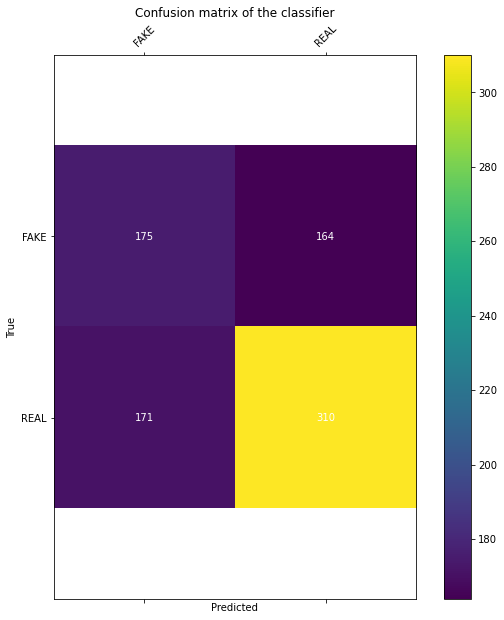

In [15]:
##plotting confusion matrix heat map
confusion_matrix_heatmap(labelsets_val, predictionsets, labels=['FAKE', 'REAL'])

In [16]:
# for loop for printing the false negatives and false positives for FAKE labels
for (sentence, true, predicted) in zip(raw_data[0:820], labelsets_val, predictionsets):
    if true == 'FAKE':
        if predicted == "REAL":
            print(f'Sentence:{sentence[0]} Ground Truth :{true} Predicted:{predicted}')
    elif predicted == "FAKE":
        print(f'Sentence:{sentence[0]} Ground Truth :{true} Predicted:{predicted}')

Sentence:Jim Dunnam has not lived in the district he represents for years now.a press release. Ground Truth :FAKE Predicted:REAL
Sentence:Says GOP primary opponents Glenn Grothman and Joe Leibham cast a compromise vote that cost $788 million in higher electricity costs.an online video Ground Truth :REAL Predicted:FAKE
Sentence:When Mitt Romney was governor of Massachusetts, we didnt just slow the rate of growth of our government, we actually cut it.an interview with CBN News Ground Truth :FAKE Predicted:REAL
Sentence:Women and men both are making less when you adjust for inflation than when John Kitzhaber was first elected governor.a campaign debate Ground Truth :FAKE Predicted:REAL
Sentence:Says Scott Walker favors cutting up to 350,000 families and children off health care.a campaign TV ad Ground Truth :REAL Predicted:FAKE
Sentence:Hate crimes against American Muslims and mosques have tripled after Paris and San Bernardino.a speech after a terrorist attack in Orlando Ground Truth :RE

In [17]:
# Finally, checking the accuracy of classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    #evaluating the accuracy
    accuracy= metrics.accuracy_score(test_true, test_pred)
    #printing precision, recall, f score, accuracy
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])
    print(f"accuracy: {accuracy}")

({'bush': 1, 'tax': 1, 'cuts': 1, 'helped': 1, 'to': 1, 'create': 1, 'substantial': 1, 'part': 1, 'of': 1, 'deficit': 1, 'radio': 1, 'interview': 1, 'long': 1, 'subject': 'bush-administration,deficit,taxes', 'speaker': 'dennis-kucinich', 'job_title': 'U.S. representative', 'state_info': 'Ohio', 'party_affiliation': 'democrat', 'barely_true_counts': 1, 'false_counts': 3, 'half_true_counts': 4, 'mostly_true_counts': 6, 'pants_on_fire_counts': 0}, 'REAL')
Training Classifier...
Done training!
Precision: 0.608512
Recall: 0.611518
F Score:0.607827
accuracy: 0.6115178135675939
